## Set up

In [1]:
import os
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import pyarrow as pa
import pyarrow.parquet as pq
import scipy.optimize as opt
import matplotlib.pyplot as plt

from os.path import dirname, join 
import sys 
sys.path.insert(0, join(dirname('notebooks'), '..'))

BASE_PATH = 'D:/KIMoDIs/global-groundwater-models-main'

DATA_PATH = os.path.join(BASE_PATH, 'data')
MODEL_PATH = os.path.join(BASE_PATH, 'models')
RESULT_PATH = os.path.join(BASE_PATH, 'results')

# Roughly 80/10/10
TRAIN_PERIOD = (pd.Timestamp(1990, 1, 1), pd.Timestamp(2010, 1, 1))
VAL_PERIOD = (pd.Timestamp(2010, 1, 1), pd.Timestamp(2013, 1, 1))
TEST_PERIOD = (pd.Timestamp(2013, 1, 1), pd.Timestamp(2016, 1, 1))

TIME_IDX = pd.date_range(TRAIN_PERIOD[0], TEST_PERIOD[1], freq='W-SUN', inclusive='neither', name='time').to_frame().reset_index(drop=True)
TIME_IDX.index.name = 'time_idx'
TIME_IDX = TIME_IDX.reset_index()

D:\KIMoDIs\GGWM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load newly processed features
features_df = pq.read_table(os.path.join(DATA_PATH, 'features_df.parquet'))
features_df = features_df.to_pandas()

In [4]:
# Load gwl from Alex
gwl_df = pd.read_feather(os.path.join(DATA_PATH, 'temporal.feather'))
gwl_df = gwl_df[['proj_id', 'x', 'y', 'time', 'gwl']]
# Load static data (old) from Alex
# old_static_df = pd.read_feather(os.path.join(DATA_PATH, 'static.feather'))

print('Currently',
       len(gwl_df[~gwl_df['proj_id'].isin(features_df['proj_id'].unique())]['proj_id'].unique()),
      'sites do not have information on the exogenous features.'
)

Currently 94 sites do not have information on the exogenous features.


In [5]:
# Training, validation and test dataset
train_df = gwl_df[gwl_df['time'].between(*TRAIN_PERIOD)]
val_df = gwl_df[gwl_df['time'].between(*VAL_PERIOD)]
test_df = gwl_df[gwl_df['time'].between(*TEST_PERIOD)]

## Filter out time series in the test data with less than 3 years of observations

- TS length should be equal to obtain comparable metrics in the end.
- Only use complete data, no interpolation (yet -> if too few datapoints we also need to interpolate in test and val set)

In [6]:
test_length_ts = pd.DataFrame(test_df['proj_id'].value_counts()).reset_index()
print(
    len(test_length_ts[test_length_ts['count']<156]),
    'time series have fewer than 3 years of gwl observations in the test data.',
    'Total number of time series:', len(test_length_ts['proj_id'].unique())
)

3502 time series have fewer than 3 years of gwl observations in the test data. Total number of time series: 12262


In [ ]:
# 3 years -> 156 weeks
# Nr of weeks for the 3 years depends on the starting date, 06.01 in this case!
# test_df[test_df['proj_id']=='SH_10L54086004']
# filtered_test_length_ts[filtered_test_length_ts['count']==156]

In [8]:
filtered_test = test_df[test_df['proj_id'].isin(test_df['proj_id'].value_counts()[lambda x: x==156].index.tolist())]

In [9]:
len(filtered_test['proj_id'].unique())

8760

## Filter out time series in the validation data with less than 3 years of observations

- Subset to the sites that are in the training should be done in the end.

In [10]:
val_length_ts = pd.DataFrame(val_df['proj_id'].value_counts()).reset_index()
print(
    len(val_length_ts[val_length_ts['count']<157]),
    'time series have fewer than 3 years of gwl observations in the test data.',
    'Total number of time series:', len(val_length_ts['proj_id'].unique())
)

3192 time series have fewer than 3 years of gwl observations in the test data. Total number of time series: 12237


In [ ]:
# 3 years -> 157 weeks!
# filtered_val_length_ts[filtered_val_length_ts['count']==157]
# val_df[val_df['proj_id']=='SH_10L54086004']

In [11]:
filtered_val = val_df[val_df['proj_id'].isin(val_df['proj_id'].value_counts()[lambda x: x == 157].index.tolist())]

In [12]:
len(filtered_val['proj_id'].unique())

9045

## Training data should be at least 6 years long and reach until the validation set 

Further conditions: 
- maximum gap 4 weeks
- greater gaps only allowed before 2004 (these will be cut off)
- Approach: 
    - first the minimum dates are set (at least 4 weeks before 2009-12-27 and max 4 weeks after the 2004-01-04)
    - then we filter for time series with gaps, interpolate or remove 

In [13]:
train_df[train_df['time']=='2004-01-04']

,proj_id,x,y,time,gwl
1042,SH_10L54131001,204,1,2004-01-04,4.816406
2381,SH_10L54086002,194,2,2004-01-04,-1.500000
3172,SH_10L54154005,206,3,2004-01-04,10.640625
3173,SH_10L54154006,206,3,2004-01-04,10.640625
3174,SH_10L54154007,206,3,2004-01-04,10.640625
...,...,...,...,...,...
13664841,BY_25668,352,788,2004-01-04,651.000000
13666197,BY_25142,370,788,2004-01-04,802.500000
13667348,BY_13103,289,789,2004-01-04,721.000000
13668514,BY_25700,350,792,2004-01-04,673.000000


In [14]:
# 4 week gaps are allowed, choose as last day 2009-11-29 (2009-12-27 minus 4 weeks) 
# and as minimum first day 2004-02-01 (4 weeks from 2004-01-04)
# Hence, 2007-12-02 should be the maximum date we include
max_date = pd.to_datetime('2009-11-29') 
min_date = pd.to_datetime('2004-02-01')
filtered_train = train_df.groupby('proj_id').filter(lambda x: (x['time'].max() >= max_date) & (x['time'].min() <= min_date))

In [15]:
filtered_train_length_ts = pd.DataFrame(filtered_train['proj_id'].value_counts()).reset_index()
print(
    len(filtered_train_length_ts[filtered_train_length_ts['count']<=312]),
    'time series with less than 6 years of gwl observations in the training data.'
)

130 time series with less than 6 years of gwl observations in the training data.


In [16]:
len(filtered_train['proj_id'].unique())

10303

## Detect jumps in the gw-levels (training, validation and test)

In [17]:
# Detect jumps
from utils import detect_jumps

filtered_train = filtered_train.groupby('proj_id').apply(detect_jumps, column = 'gwl', threshold = 50)
filtered_train.reset_index(drop=True, inplace=True)

filtered_val = filtered_val.groupby('proj_id').apply(detect_jumps, column = 'gwl', threshold = 50)
filtered_val.reset_index(drop=True, inplace=True)

filtered_test = filtered_test.groupby('proj_id').apply(detect_jumps, column = 'gwl', threshold = 50)
filtered_test.reset_index(drop=True, inplace=True)

In [18]:
print(
    len(filtered_train[filtered_train['is_jump']==True]['proj_id'].unique()),
    'timeseries have extreme jumps in the training data.'
)

261 timeseries have extreme jumps in the training data.


In [19]:
print(
    len(filtered_val[filtered_val['is_jump']==True]['proj_id'].unique()),
    'timeseries have extreme jumps in the training data.'
)

22 timeseries have extreme jumps in the training data.


In [20]:
print(
    len(filtered_test[filtered_test['is_jump']==True]['proj_id'].unique()),
    'timeseries have extreme jumps in the test data.'
)

29 timeseries have extreme jumps in the test data.


In [21]:
# Just remove the timepoint with the large jump
filtered_train = filtered_train[filtered_train['is_jump']==False]
filtered_val = filtered_val[filtered_val['is_jump']==False]
filtered_test = filtered_test[filtered_test['is_jump']==False]

# Code to remove the id's with large jumps
# id_jumps_rm = filtered_train[filtered_train['is_jump']==True]['proj_id'].unique()
# filtered_train = filtered_train[~filtered_train['proj_id'].isin(id_jumps_rm)]

# id_jumps_rm_val = filtered_val[filtered_val['is_jump']==True]['proj_id'].unique()
# filtered_val = filtered_val[~filtered_val['proj_id'].isin(id_jumps_rm_val)]

# id_jumps_rm_test = filtered_test[filtered_test['is_jump']==True]['proj_id'].unique()
# filtered_test = filtered_test[~filtered_test['proj_id'].isin(id_jumps_rm_test)]

# Example jump
# subset = train_df[(train_df['proj_id']=='TH_5138000176') & (train_df['time'] <= '2011-07-31')][['proj_id', 'time', 'gwl', 'is_jump']].tail(60)
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# plt.plot(subset['time'], subset['gwl'], marker='o', linestyle='-', color='b', label='Groundwater Level')
# plt.xlabel('Time')
# plt.ylabel('Groundwater Level')
# plt.title('GWL Time Series TH_5138000176')
# plt.legend()
# plt.grid(True)
# plt.show()

In [22]:
# Calculate time diff to next observation per proj id
filtered_train['time_diff'] = filtered_train.groupby('proj_id')['time'].diff()
filtered_val['time_diff'] = filtered_val.groupby('proj_id')['time'].diff()
filtered_test['time_diff'] = filtered_test.groupby('proj_id')['time'].diff()

## Remove Time Series with gaps greater than 4 weeks (training data)

- Training: 
    - Remove timeseries with gaps > 28 days within 2004 - 2010
    - If greater gaps occur before 2004, cut time series

In [23]:
# Remove TS with gaps > 28 days within 2002-01-06 - 2007-12-30 
filtered_train_gap = filtered_train[filtered_train['time_diff'] > pd.Timedelta('28 days')]
filtered_train_gap_after2001 = filtered_train_gap[filtered_train_gap['time']>='2004-01-04']
sites_rm = filtered_train_gap_after2001['proj_id'].unique()

print(len(sites_rm), 
      'sites have at least one gap between 2004 and 2010 greater than 4 weeks in the training data')

# This step is dubious and should be changed (maybe was added later?)
# filtered_train = filtered_train[~filtered_train['proj_id'].isin(sites_rm)]

2441 sites have at least one gap between 2004 and 2010 greater than 4 weeks in the training data


In [24]:
# After subset recalculate the gaps > 28 days
filtered_train_gap = filtered_train[filtered_train['time_diff'] > pd.Timedelta('28 days')]

In [25]:
# Subset to the latest occurring gap
filtered_train_gap = filtered_train_gap.loc[filtered_train_gap.groupby('proj_id')['time'].idxmax()]

In [26]:
filtered_train[(filtered_train['proj_id']=='BB_27400050') & (filtered_train['time']>='1997-06-29')]
# ST_49399327
# 2000-01-23

,proj_id,x,y,time,gwl,is_jump,time_diff
22901,BB_27400050,423,170,1997-06-29,72.8750,False,56 days
22902,BB_27400050,423,170,1997-07-06,72.8750,False,7 days
22903,BB_27400050,423,170,1997-07-13,72.8125,False,7 days
22904,BB_27400050,423,170,1997-07-20,72.8125,False,7 days
22905,BB_27400050,423,170,1997-07-27,72.8125,False,7 days
...,...,...,...,...,...,...,...
23549,BB_27400050,423,170,2009-11-29,73.1875,False,7 days
23550,BB_27400050,423,170,2009-12-06,73.1250,False,7 days
23551,BB_27400050,423,170,2009-12-13,73.1875,False,7 days
23552,BB_27400050,423,170,2009-12-20,73.0625,False,7 days


In [27]:
# Cut the time series that have gaps
cut_filtered_train = filtered_train_gap[['proj_id', 'time']].merge(filtered_train, on='proj_id').query('time_x <= time_y')
cut_filtered_train = cut_filtered_train[['proj_id', 'x', 'y', 'time_y', 'gwl', 'is_jump', 'time_diff']]
cut_filtered_train = cut_filtered_train.rename(columns={'time_y': 'time'})

In [28]:
# Merge back to the time series that don't have large gaps in filtered_train 
filtered_train = pd.concat([filtered_train[~filtered_train['proj_id'].isin(cut_filtered_train['proj_id'].unique())], cut_filtered_train])

In [29]:
# Recalculate time diff and check again
# No time diff > 4 weeks in the training data
filtered_train = filtered_train.assign(time_diff=filtered_train.groupby('proj_id')['time'].diff())
print(filtered_train[filtered_train['time_diff'] > pd.Timedelta('28 days')])

Empty DataFrame
Columns: [proj_id, x, y, time, gwl, is_jump, time_diff]
Index: []


In [54]:
# Check for gaps in validation and test set (there should be no gaps > 4 weeks)
# filtered_val[filtered_val['time_diff'] > pd.Timedelta('28 days')]
# filtered_test[filtered_test['time_diff'] > pd.Timedelta('7 days')]

In [30]:
len(filtered_train['proj_id'].unique())

7862

In [39]:
interpolated_ts_train = filtered_train[filtered_train['time_diff'] > pd.Timedelta('7 days')]['proj_id'].unique()
interpolated_ts_val = filtered_val[filtered_val['time_diff'] > pd.Timedelta('7 days')]['proj_id'].unique()

np.save(os.path.join(DATA_PATH, 'interpolated_ts_train.npy'), interpolated_ts_train)
np.save(os.path.join(DATA_PATH, 'interpolated_ts_val.npy'), interpolated_ts_val)

## Linear interpolation

In [55]:
# Interpolate groundwater levels up to 4 weeks (default limit = 4)
def interpolate_gwl(dataframe, interpolation_column, resample_freq='7D', limit=4):
    groups = []
    for well_id, group in dataframe.groupby('proj_id'):
        _df = group.set_index('time')[interpolation_column].resample(resample_freq).asfreq().interpolate(method='linear', limit=limit).reset_index().copy()
        for col in group.columns.difference([interpolation_column, 'time']):  # Retain other columns
            _df[col] = group[col].iloc[0]
        _df['proj_id'] = well_id
        groups.append(_df)
    result_df = pd.concat(groups).reset_index(drop=True)
    return result_df

In [56]:
# from utils import interpolate_gwl
filtered_train = interpolate_gwl(filtered_train, 'gwl')
filtered_val = interpolate_gwl(filtered_val, 'gwl')
filtered_test = interpolate_gwl(filtered_test, 'gwl')

In [58]:
# Recalculate time diff and check again
# No time diff >  weeks in the training data
filtered_train = filtered_train.assign(time_diff=filtered_train.groupby('proj_id')['time'].diff())
filtered_val = filtered_val.assign(time_diff=filtered_val.groupby('proj_id')['time'].diff())
filtered_test = filtered_test.assign(time_diff=filtered_test.groupby('proj_id')['time'].diff())
print(filtered_val[filtered_val['time_diff'] > pd.Timedelta('7 days')])

Empty DataFrame
Columns: [time, gwl, is_jump, proj_id, time_diff, x, y]
Index: []


## Add exogenous features

In [60]:
filtered_train = filtered_train[['proj_id', 'time','gwl']]
filtered_val = filtered_val[['proj_id', 'time','gwl']]
filtered_test = filtered_test[['proj_id', 'time','gwl']]

In [ ]:
# Subset validation and training data so that they only share the same sites
filtered_val = filtered_val[filtered_val['proj_id'].isin(filtered_train['proj_id'].unique())]
filtered_train = filtered_train[filtered_train['proj_id'].isin(filtered_val['proj_id'].unique())]

In [66]:
print(len(filtered_train['proj_id'].unique()) == len(filtered_val['proj_id'].unique()))
print(len(filtered_train['proj_id'].unique()))

True
6419


In [67]:
# Merge features
filtered_train = filtered_train.merge(features_df, on=['proj_id', 'time'], how='left')
filtered_val = filtered_val.merge(features_df, on=['proj_id', 'time'], how='left')
filtered_test = filtered_test.merge(features_df, on=['proj_id', 'time'], how='left')

In [68]:
# Not all sites have exogenous variables (training)
filtered_train = filtered_train[filtered_train['proj_id'].isin(features_df['proj_id'].unique())]
filtered_val = filtered_val[filtered_val['proj_id'].isin(features_df['proj_id'].unique())]
filtered_test = filtered_test[filtered_test['proj_id'].isin(features_df['proj_id'].unique())]

In [ ]:
# Check for Nans
filtered_train.isnull().any()

In [70]:
print('The final training data contain information for',
      len(filtered_train['proj_id'].unique()), 
      'sites'
)

The final training data contain information for 6364 sites


In [72]:
print('The final validation data contain information for',
      len(filtered_val['proj_id'].unique()), 
      'sites'
)

The final validation data contain information for 6364 sites


In [73]:
print('The final test data contain information for',
      len(filtered_test['proj_id'].unique()), 
      'sites'
)

The final test data contain information for 8713 sites


In [74]:
# Add lon and lat
old_static_df = pd.read_feather(os.path.join(DATA_PATH, 'static.feather'))
filtered_train = filtered_train.merge(old_static_df[['proj_id', 'lon', 'lat']], on='proj_id', how='left')
filtered_val = filtered_val.merge(old_static_df[['proj_id', 'lon', 'lat']], on='proj_id', how='left')
filtered_test = filtered_test.merge(old_static_df[['proj_id', 'lon', 'lat']], on='proj_id', how='left')

In [75]:
# Add sinusoidal curve fitted to temperature as variable 
# Fitting function for sinusoidal fit 
# Quelle:
# https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy
def fit_sin(yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", 
    "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    
    tt = np.linspace(0,len(yy)-1,len(yy))
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding zero frequency "peak" (related to offset)
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = opt.curve_fit(sinfunc, tt, yy, p0=guess) #opt
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    
    # # # original return
    # return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, 
    #         "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}
    
    # my return
    out = fitfunc(tt)
    out = out-np.mean(out)
    
    return out

sinT = filtered_train.groupby('proj_id').apply(lambda group: fit_sin(group['temp']))
sinT_val = filtered_val.groupby('proj_id').apply(lambda group: fit_sin(group['temp']))
sinT_test = filtered_test.groupby('proj_id').apply(lambda group: fit_sin(group['temp']))

In [76]:
sinT = pd.DataFrame(sinT)
sinT = sinT.rename(columns={0: 'sin_temp'})
sinT = sinT.explode('sin_temp').reset_index()

sinT_val = pd.DataFrame(sinT_val)
sinT_val = sinT_val.rename(columns={0: 'sin_temp'})
sinT_val = sinT_val.explode('sin_temp').reset_index()

sinT_test = pd.DataFrame(sinT_test)
sinT_test = sinT_test.rename(columns={0: 'sin_temp'})
sinT_test = sinT_test.explode('sin_temp').reset_index()

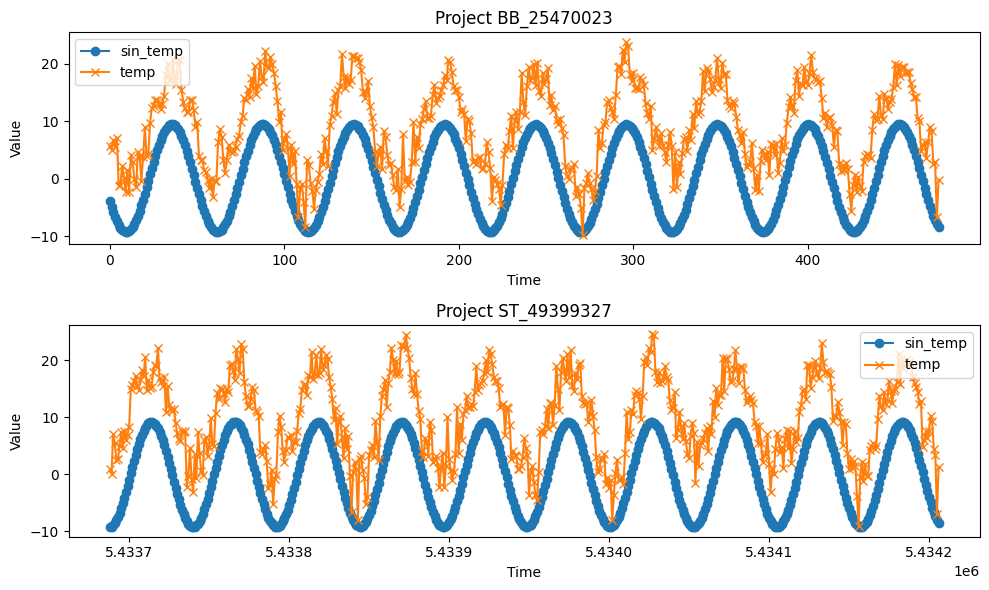

In [77]:
sinT['temp'] = filtered_train['temp']
# Checking if curve aligns
# Filter the DataFrame for two proj_id's of interest
proj_id_filter = ['BB_25470023', 'ST_49399327']
filtered_df = sinT[sinT['proj_id'].isin(proj_id_filter)]

# Create subplots for each proj_id
fig, axes = plt.subplots(nrows=len(proj_id_filter), ncols=1, figsize=(10, 6))

# Plot the seasonality of 'sinT_vals' and 'temp' for each proj_id
for i, proj_id in enumerate(proj_id_filter):
    proj_df = filtered_df[filtered_df['proj_id'] == proj_id]
    ax = axes[i]
    ax.plot(proj_df.index, proj_df['sin_temp'], label='sin_temp', marker='o')
    ax.plot(proj_df.index, proj_df['temp'], label='temp', marker='x')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title(f'Project {proj_id}')
    ax.legend()

# Adjust subplot spacing
plt.tight_layout()

# Show the plot
plt.show()

In [78]:
filtered_train['sin_temp'] = sinT['sin_temp']
filtered_val['sin_temp'] = sinT_val['sin_temp']
filtered_test['sin_temp'] = sinT_test['sin_temp']

In [79]:
# Add time index
filtered_train = filtered_train.merge(TIME_IDX, on='time', how='left')
filtered_val = filtered_val.merge(TIME_IDX, on='time', how='left')
filtered_test = filtered_test.merge(TIME_IDX, on='time', how='left')

In [80]:
# Rename gwn_recharge
filtered_train.rename(columns={'gwn_recharge':'gw_recharge'}, inplace=True)
filtered_val.rename(columns={'gwn_recharge':'gw_recharge'}, inplace=True)
filtered_test.rename(columns={'gwn_recharge':'gw_recharge'}, inplace=True)

In [81]:
# Save data
table_train = pa.Table.from_pandas(filtered_train)
table_val = pa.Table.from_pandas(filtered_val)
table_test = pa.Table.from_pandas(filtered_test)
pq.write_table(table_train, os.path.join(DATA_PATH, 'train_df.parquet'))
pq.write_table(table_val, os.path.join(DATA_PATH, 'val_df.parquet'))
pq.write_table(table_test, os.path.join(DATA_PATH, 'test_df.parquet'))